### Fraud Analytics Assignment 5 :
### Team Members : 
### 1.CS22BTECH11012 - Bolla NehaSree
### 2.CS22BTECH11043 - Nethi Keerthana
### 3.ES22BTECH11025 - N.Krishna Chaitanya

Total unique edges before filtering: 5358
Edges after applying min_transactions=2: 4160 (77.64%)
Graph Info:
Number of nodes: 746
Number of edges: 4160
Average degree: 11.1528
Density: 0.0075
Number of isolated nodes: 0
Graph after removing isolated nodes: 746 nodes, 4160 edges
Degree Distribution:


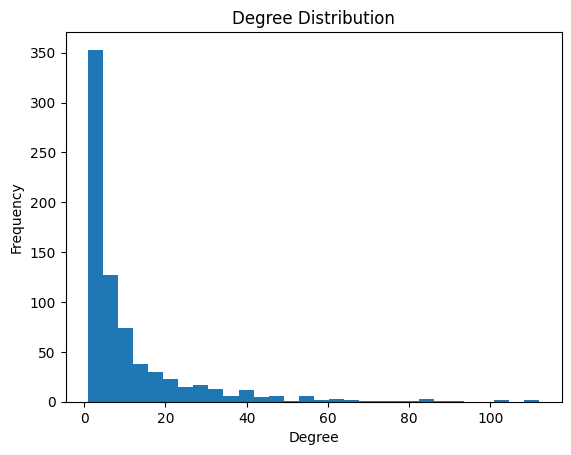

Number of weakly connected components: 6
Sizes of components: [734, 3, 2, 2, 2, 3]
Using largest component: 734 nodes, 4153 edges
Epoch 1, Loss: 10031.4487
Epoch 2, Loss: 9915.2730
Epoch 3, Loss: 9876.8948
Epoch 4, Loss: 9848.5835
Epoch 5, Loss: 9845.3789
Epoch 6, Loss: 9855.0686
Epoch 7, Loss: 9835.4695
Epoch 8, Loss: 9857.9648
Epoch 9, Loss: 9816.8730
Epoch 10, Loss: 9819.8479


In [1]:
#Import necessary modules
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
from torch.optim import Adam
from collections import defaultdict
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

#Load the data and aggregate multiple edges and take average of their sum
def load_and_preprocess_data(file_path, min_transactions=2):
    df = pd.read_excel(file_path)
    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['Sender'], row['Receiver'], weight=row['Amount'])
    
    simple_G = nx.DiGraph()
    edge_counts = defaultdict(int)
    edge_amounts = defaultdict(float)
    
    # Compute both the count of transactions and the total amount for each edge
    for u, v, data in G.edges(data=True):
        edge_counts[(u, v)] += 1
        edge_amounts[(u, v)] += data['weight']
    
    # Analyze the impact of min_transactions
    total_edges = len(edge_counts)
    filtered_edges = sum(1 for count in edge_counts.values() if count >= min_transactions)
    print(f"Total unique edges before filtering: {total_edges}")
    print(f"Edges after applying min_transactions={min_transactions}: {filtered_edges} ({filtered_edges/total_edges*100:.2f}%)")
    
    # Add edges to simple_G with both count and amount as weights
    for (u, v), count in edge_counts.items():
        if count >= min_transactions:
            simple_G.add_edge(u, v, weight_count=count, weight_amount=edge_amounts[(u, v)]/count)
    
    return simple_G


# Implementation of the Node2Vec algorithm for learning node embeddings in a graph.
# Node2Vec generates low-dimensional vector representations for nodes by simulating
# biased random walks and using them to train a skip-gram model.
class Node2Vec:
    # Initialize the Node2Vec model with graph and hyperparameters.
    # Args:
    #   graph: NetworkX graph object representing the input graph.
    #   dimensions: Integer, size of the node embeddings (default: 128).
    #   walk_length: Integer, length of each random walk (default: 40).
    #   num_walks: Integer, number of random walks per node (default: 60).
    #   p: Float, return parameter controlling likelihood of revisiting a node (default: 1.0).
    #   q: Float, in-out parameter controlling exploration vs. local search (default: 1.0).
    #   window_size: Integer, context window size for skip-gram training (default: 5).
    def __init__(self, graph, dimensions=128, walk_length=40, num_walks=60, p=1.0, q=1.0, window_size=5):
        self.graph = graph  # Store the input graph.
        self.dimensions = dimensions  # Dimensionality of the node embeddings.
        self.walk_length = walk_length  # Number of nodes in each random walk.
        self.num_walks = num_walks  # Number of walks to simulate per node.
        self.p = p  # Return parameter for biased random walks.
        self.q = q  # In-out parameter for biased random walks.
        self.window_size = window_size  # Context window size for training pairs.
        # Create mappings for node-to-index and index-to-node for efficient processing.
        self.node2idx = {node: idx for idx, node in enumerate(graph.nodes())}
        self.idx2node = {idx: node for node, idx in self.node2idx.items()}
        self.num_nodes = len(self.node2idx)  # Total number of nodes in the graph.
        
    # Compute transition probabilities for the next step in a random walk.
    # Args:
    #   prev: Previous node in the walk (used for second-order bias).
    #   curr: Current node in the walk.
    # Returns:
    #   neighbors: List of neighboring nodes of the current node.
    #   probs: Normalized transition probabilities for each neighbor.
    def compute_transition_probs(self, prev, curr):
        # Get all neighbors of the current node.
        neighbors = list(self.graph.neighbors(curr))
        probs = []
        for neighbor in neighbors:
            # Retrieve edge weight (e.g., number of transactions or transaction amount).
            # Default to 1.0 if no weight is specified.
            weight = self.graph[curr][neighbor].get('weight_amount', 1.0)
            # Note: The commented line suggests an alternative weight based on total transaction amount.
            # weight = self.graph[curr][neighbor].get('weight_amount', 1.0)
            
            # Optional: Apply logarithmic scaling to reduce the impact of extreme weights.
            # scaled_weight = np.log1p(weight)  # log1p(x) = log(1 + x)
            
            # Apply Node2Vec biases based on the relationship between nodes:
            # - If neighbor is the previous node, apply return parameter (1/p).
            # - If neighbor is connected to the previous node, no bias (weight * 1.0).
            # - Otherwise, apply in-out parameter (1/q) for exploration.
            if neighbor == prev:
                prob = (1.0 / self.p) * weight
            elif self.graph.has_edge(neighbor, prev):
                prob = 1.0 * weight
            else:
                prob = (1.0 / self.q) * weight
            probs.append(prob)
        
        # Convert probabilities to a NumPy array and normalize to sum to 1.
        probs = np.array(probs)
        probs /= probs.sum()
        return neighbors, probs
    
    # Simulate biased random walks on the graph to generate sequences of nodes.
    # Returns:
    #   walks: List of walks, where each walk is a list of node indices.
    def simulate_walks(self):
        walks = []  # Store all generated walks.
        nodes = list(self.graph.nodes())  # Get all nodes in the graph.
        # Perform num_walks iterations of random walks.
        for _ in range(self.num_walks):
            random.shuffle(nodes)  # Randomize node order to ensure diverse walks.
            for node in nodes:
                walk = [node]  # Start the walk with the current node.
                curr = node  # Set the current node.
                # Generate a walk of length walk_length (or less if no neighbors).
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.graph.neighbors(curr))
                    if not neighbors:  # Stop if the current node has no neighbors.
                        break
                    if len(walk) > 1:
                        # Use biased random walk for second-order transitions.
                        prev = walk[-2]  # Get the previous node.
                        neighbors, probs = self.compute_transition_probs(prev, curr)
                        # Select the next node based on transition probabilities.
                        curr = random.choices(neighbors, probs)[0]
                    else:
                        # For the first step, choose a neighbor randomly (no previous node).
                        curr = random.choice(neighbors)
                    walk.append(curr)  # Add the selected node to the walk.
                # Convert node IDs to indices and store the walk.
                walks.append([self.node2idx[node] for node in walk])
        return walks
    
    # Generate training pairs for the skip-gram model from random walks.
    # Args:
    #   walks: List of walks, where each walk is a list of node indices.
    # Returns:
    #   pairs: List of (center_node, context_node) index pairs for training.
    def generate_training_data(self, walks):
        pairs = []  # Store (center, context) node index pairs.
        for walk in walks:
            # Iterate over each node in the walk as the center node.
            for i in range(len(walk)):
                # Consider context nodes within the window_size before and after.
                for j in range(max(0, i - self.window_size), min(len(walk), i + self.window_size + 1)):
                    if i != j:  # Exclude the center node itself.
                        pairs.append((walk[i], walk[j]))
        return pairs

# SkipGram model for learning node embeddings using PyTorch.
class SkipGram(nn.Module):
    # Initialize the SkipGram model.
    # Args:
    #   num_nodes: Integer, total number of nodes in the graph.
    #   dimensions: Integer, size of node embeddings.
    def __init__(self, num_nodes, dimensions):
        super(SkipGram, self).__init__()
        self.num_nodes = num_nodes  # Store number of nodes.
        self.dimensions = dimensions  # Store embedding size.
        self.embedding = nn.Embedding(num_nodes, dimensions)  # Center node embeddings.
        self.context = nn.Embedding(num_nodes, dimensions)  # Context node embeddings.
        self.init_weights()  # Initialize weights.
    
    # Initialize embedding weights with uniform distribution.
    def init_weights(self):
        initrange = 0.5 / self.dimensions  # Define initialization range.
        self.embedding.weight.data.uniform_(-initrange, initrange)  # Init center embeddings.
        self.context.weight.data.uniform_(-initrange, initrange)  # Init context embeddings.
    
    # Compute similarity score between center and context node embeddings.
    # Args:
    #   u: Tensor, indices of center nodes.
    #   v: Tensor, indices of context nodes.
    # Returns:
    #   score: Tensor, dot product scores for node pairs.
    def forward(self, u, v):
        u_embed = self.embedding(u)  # Get center node embeddings.
        v_embed = self.context(v)  # Get context node embeddings.
        score = torch.sum(u_embed * v_embed, dim=1)  # Compute dot product.
        return score

# Train Node2Vec model using SkipGram.
# Args:
#   node2vec: Node2Vec instance.
#   epochs: Integer, number of training epochs (default: 20).
#   batch_size: Integer, size of training batches (default: 128).
#   learning_rate: Float, learning rate for Adam optimizer (default: 0.01).
# Returns:
#   embeddings: Numpy array of learned node embeddings.
def train_node2vec(node2vec, epochs=20, batch_size=128, learning_rate=0.01):
    walks = node2vec.simulate_walks()  # Generate random walks.
    pairs = node2vec.generate_training_data(walks)  # Create training pairs.
    
    model = SkipGram(node2vec.num_nodes, node2vec.dimensions)  # Initialize SkipGram.
    optimizer = Adam(model.parameters(), lr=learning_rate)  # Set Adam optimizer.
    criterion = nn.BCEWithLogitsLoss()  # Use BCE loss with logits.
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Select device.
    model.to(device)  # Move model to device.
    
    for epoch in range(epochs):
        random.shuffle(pairs)  # Shuffle training pairs.
        total_loss = 0
        for i in range(0, len(pairs), batch_size):
            batch = pairs[i:i + batch_size]  # Get batch of pairs.
            u = torch.LongTensor([pair[0] for pair in batch]).to(device)  # Center nodes.
            v = torch.LongTensor([pair[1] for pair in batch]).to(device)  # Context nodes.
            labels = torch.ones(len(batch)).to(device)  # Positive labels.
            
            optimizer.zero_grad()  # Clear gradients.
            scores = model(u, v)  # Compute scores for positive pairs.
            loss = criterion(scores, labels)  # Compute positive loss.
            
            neg_v = torch.randint(0, node2vec.num_nodes, (len(batch),)).to(device)  # Negative samples.
            neg_scores = model(u, neg_v)  # Compute scores for negative pairs.
            neg_labels = torch.zeros(len(batch)).to(device)  # Negative labels.
            neg_loss = criterion(neg_scores, neg_labels)  # Compute negative loss.
            
            total_batch_loss = loss + neg_loss  # Combine losses.
            total_batch_loss.backward()  # Backpropagate.
            optimizer.step()  # Update weights.
            total_loss += total_batch_loss.item()  # Accumulate loss.
        
        print(f'Epoch {epoch + 1}, Loss: {total_loss:.4f}')  # Print epoch loss.
    
    return model.embedding.weight.cpu().detach().numpy()  # Return learned embeddings.
    
#This finds optimal number of clusters as per silhoutte score
def find_optimal_clusters(embeddings, max_k=10):
    sse = []
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        sse.append(kmeans.inertia_)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(embeddings, labels))
        else:
            silhouette_scores.append(-1)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k+1), sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_k+1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.show()
    
    optimal_k = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    return optimal_k
    
#This plots KMeans clustering 
def cluster_and_evaluate(embeddings, node2idx, p, q, dim, n_clusters):
    # Normalize embeddings
    #embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # KMeans clustering with the optimal k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)
    kmeans_silhouette = silhouette_score(embeddings, kmeans_labels) if len(set(kmeans_labels)) > 1 else -1
    kmeans_db = davies_bouldin_score(embeddings, kmeans_labels) if len(set(kmeans_labels)) > 1 else float('inf')
    
    # Print scores
    print(f"\nParameters: p={p}, q={q}, dim={dim}, n_clusters={n_clusters}")
    print(f"KMeans - Silhouette: {kmeans_silhouette:.4f}, Davies-Bouldin: {kmeans_db:.4f}")
    
    # Visualize
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=kmeans_labels, palette='deep', legend=None)
    plt.title(f'KMeans Clustering (p={p}, q={q}, dim={dim}, n={n_clusters})')
    plt.show()
    
    results = {
        'p': p, 'q': q, 'dim': dim, 'n_clusters': n_clusters,
        'kmeans_silhouette': kmeans_silhouette, 'kmeans_db': kmeans_db,
        'kmeans_labels': kmeans_labels
    }
    
    return results

# Load the graph
G = load_and_preprocess_data('Payments.xlsx', min_transactions=2)

# Print graph info
print("Graph Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Average degree: {avg_degree:.4f}")
print(f"Density: {nx.density(G):.4f}")

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")
G.remove_nodes_from(isolated_nodes)
print(f"Graph after removing isolated nodes: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Degree distribution
print("Degree Distribution:")
degrees = [degree for node, degree in G.degree()]
plt.hist(degrees, bins=30)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

# Connected components analysis
components = list(nx.weakly_connected_components(G))
print(f"Number of weakly connected components: {len(components)}")
component_sizes = [len(c) for c in components]
print(f"Sizes of components: {component_sizes}")
if len(components) > 1:
    largest_component = max(components, key=len)
    G = G.subgraph(largest_component).copy()
    print(f"Using largest component: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Define Node2Vec parameters (use best from tuning)
p, q, dim = 1.0, 1.0, 128
walk_length, num_walks = 10, 80
window_size, epochs, learning_rate = 5, 10, 0.01

# Train Node2Vec
node2vec = Node2Vec(G, dimensions=dim, walk_length=walk_length,
                    num_walks=num_walks, p=p, q=q, window_size=window_size)
embeddings = train_node2vec(node2vec, epochs=epochs, learning_rate=learning_rate)

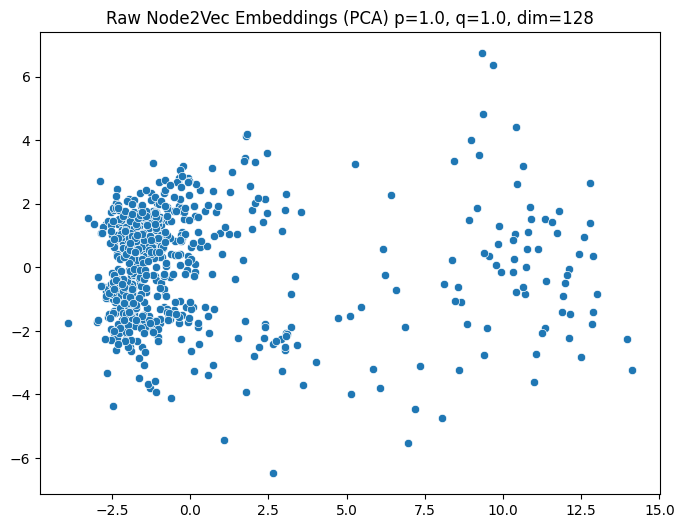

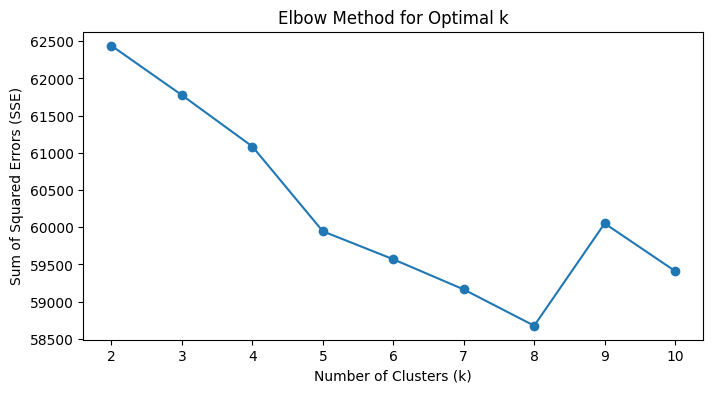

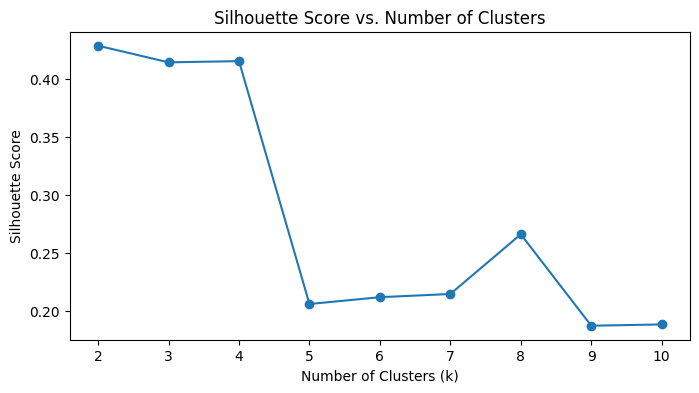

Optimal number of clusters based on Silhouette Score: 2

Parameters: p=1.0, q=1.0, dim=128, n_clusters=2
KMeans - Silhouette: 0.4283, Davies-Bouldin: 2.0737


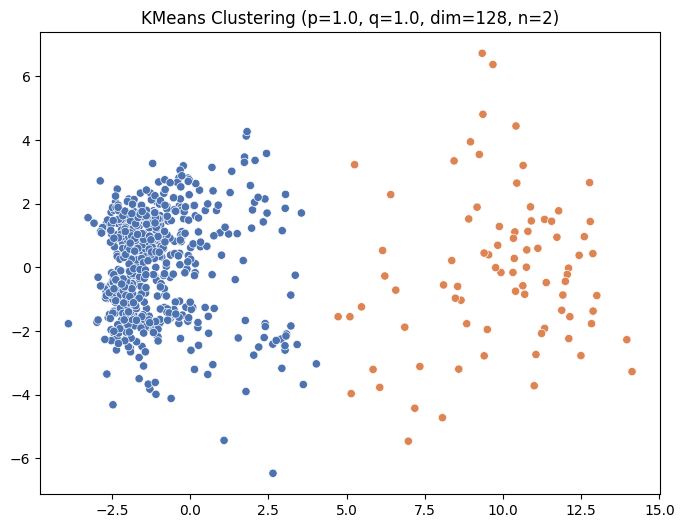


Summary of Results:
Parameters: p=1.0, q=1.0, dim=128, n_clusters=2
KMeans - Silhouette: 0.4283


In [15]:
# Visualize raw embeddings
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])
plt.title(f'Raw Node2Vec Embeddings (PCA) p={p}, q={q}, dim={dim}')
plt.show()
    
# Find optimal number of clusters
optimal_k = find_optimal_clusters(embeddings, max_k=10)
n_clusters = optimal_k
    
# Perform KMeans clustering with the optimal k and evaluate
results = cluster_and_evaluate(embeddings, node2idx=node2vec.node2idx, p=p, q=q, dim=dim, n_clusters=optimal_k)
    
# Summarize results
print("\nSummary of Results:")
print(f"Parameters: p={results['p']}, q={results['q']}, dim={results['dim']}, n_clusters={results['n_clusters']}")
print(f"KMeans - Silhouette: {results['kmeans_silhouette']:.4f}")


AGGLOMERATIVE Clustering | p=1.0, q=1.0, dim=128, n_clusters=2
Silhouette Score: 0.4472


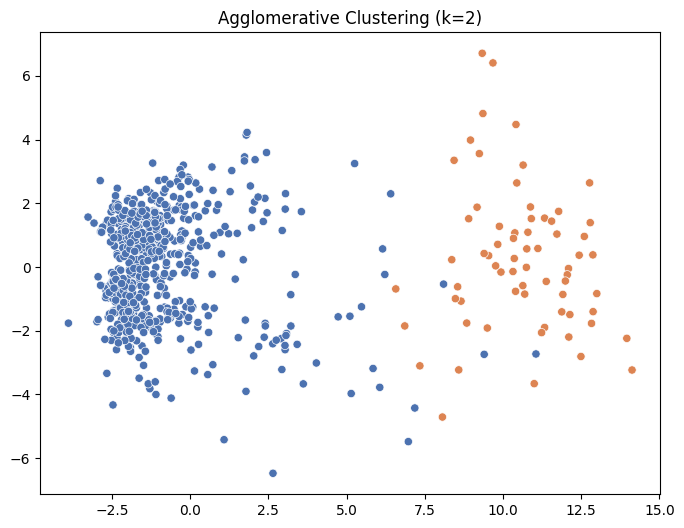

In [16]:
#This plots Agglomerative clustering with optimal k
from sklearn.cluster import AgglomerativeClustering

def agglomerative_cluster_and_plot(embeddings, p, q, dim, n_clusters=5):
    #embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(embeddings)

    silhouette = silhouette_score(embeddings, cluster_labels)
    db_score = davies_bouldin_score(embeddings, cluster_labels)

    print(f"\nAGGLOMERATIVE Clustering | p={p}, q={q}, dim={dim}, n_clusters={n_clusters}")
    print(f"Silhouette Score: {silhouette:.4f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
                    hue=cluster_labels, palette='deep', legend=None)
    plt.title(f'Agglomerative Clustering (k={n_clusters})')
    plt.show()

agglomerative_cluster_and_plot(embeddings, p, q, dim, n_clusters=optimal_k)

